# Porfolio Optimization with Multiple Risk Strategies in Python with AMPL
[![Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_4_Porfolio_Optimization_Risk_Strategies.ipynb)](https://colab.ampl.com)

Description: This notebook evaluates three distinct risk-based portfolio strategies: Semivariance Optimization, Conditional Value-at-Risk (CVaR) Optimization, and Conditional Drawdown-at-Risk (CDaR) Optimization.

Tags: finance, portfolio-optimization, cvar, cdar, semivariance

Notebook author: Mukeshwaran Baskaran <<mukesh96official@gmail.com>>

## Introduction - Semivariance, CVaR & CDaR

This project focuses on portfolio optimization, a critical aspect of investment management that aims to construct portfolios offering the best possible return for a given level of risk. By leveraging advanced optimization techniques, it evaluates three distinct risk-based portfolio strategies: **Semivariance Optimization**, **Conditional Value-at-Risk (CVaR) Optimization**, and **Conditional Drawdown-at-Risk (CDaR) Optimization**. These methods are designed to address different aspects of risk, such as downside volatility, tail risk, and drawdowns, providing investors with a robust framework to manage their investments effectively.

The analysis begins by calculating expected returns and historical performance data for a selection of assets. It then constructs optimal portfolios using each of the three strategies, balancing the trade-off between risk and return. The performance of these portfolios is evaluated using key metrics such as annualized return, volatility, Sharpe ratio, and maximum drawdown. Visualizations are provided to help investors understand the allocation of assets in each portfolio, compare cumulative returns over time, and assess the risk-return profiles of the strategies.

This project is particularly useful for investors, portfolio managers, and financial analysts seeking to enhance their understanding of risk-based portfolio construction and improve decision-making in asset allocation. It combines theoretical insights with practical implementation, offering a comprehensive toolkit for modern portfolio management.

### Relevant Books for Further Reading

1. **"Modern Portfolio Theory and Investment Analysis" by Edwin J. Elton, Martin J. Gruber, Stephen J. Brown, and William N. Goetzmann**  
   - A classic text that provides a thorough introduction to portfolio theory, including risk measures and optimization techniques.

2. **"Portfolio Optimization and Performance Analysis" by Jean-Luc Prigent**  
   - This book delves into advanced portfolio optimization methods, including CVaR and CDaR, with a focus on practical applications.

3. **"Risk Management and Financial Institutions" by John C. Hull**  
   - A comprehensive guide to risk management concepts, including Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR), and their applications in finance.

4. **"The Intelligent Asset Allocator: How to Build Your Portfolio to Maximize Returns and Minimize Risk" by William J. Bernstein**  
   - A practical guide to asset allocation and portfolio construction, emphasizing the importance of risk management.

5. **"Quantitative Equity Portfolio Management: Modern Techniques and Applications" by Edward E. Qian, Ronald H. Hua, and Eric H. Sorensen**  
   - This book explores quantitative methods for portfolio management, including optimization and risk modeling.

6. **"Financial Risk Forecasting: The Theory and Practice of Forecasting Market Risk with Implementation in R and Python" by Jon Danielsson**  
   - A hands-on guide to forecasting financial risk, with practical examples and code implementations.

These resources provide a solid foundation for understanding the theoretical and practical aspects of portfolio optimization and risk management, complementing the insights gained from this project.


---

In [1]:
# Install dependencies
%pip install amplpy yfinance matplotlib pandas numpy -q

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Implementation

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Efficient-semivariance optimization in AMPL

In [4]:
def efficient_semivariance(
    expected_returns, returns, target_return=None, benchmark=0, weight_bounds=(0, 1)
):
    """Perform efficient-semivariance optimization using AMPL."""
    ampl = AMPL()

    # Extract dimensions
    tickers = list(expected_returns.index)
    n_assets = len(tickers)
    n_periods = len(returns)

    # Define the AMPL model for Efficient Semivariance
    ampl.eval(
        r"""
        set ASSETS ordered;
        set PERIODS ordered;

        param mu{ASSETS};
        param returns{PERIODS, ASSETS};
        param benchmark;
        param target_return;
        param lb;
        param ub;

        var w{ASSETS} >= lb <= ub;
        var n{PERIODS} >= 0;
        var p{PERIODS} >= 0;

        minimize semivariance:
            sum{t in PERIODS} n[t] / card(PERIODS);

        subject to excess_returns{t in PERIODS}:
            sum{i in ASSETS} returns[t,i] * w[i] - benchmark - p[t] + n[t] = 0;

        subject to return_target:
            sum{i in ASSETS} mu[i] * w[i] >= target_return;

        subject to weights_sum:
            sum{i in ASSETS} w[i] = 1;
        """
    )

    # Set data in AMPL
    ampl.set["ASSETS"] = tickers
    ampl.set["PERIODS"] = list(range(n_periods))

    ampl.param["mu"] = {ticker: expected_returns[ticker] for ticker in tickers}
    ampl.param["returns"] = {
        (t, ticker): returns.iloc[t][ticker]
        for t in range(n_periods)
        for ticker in tickers
    }
    ampl.param["benchmark"] = benchmark
    ampl.param["target_return"] = target_return if target_return is not None else 0
    ampl.param["lb"] = weight_bounds[0]
    ampl.param["ub"] = weight_bounds[1]

    # Solve the optimization problem
    ampl.solve(solver="gurobi", gurobi_options="outlev=1")

    # Check if the problem was solved successfully
    assert ampl.solve_result == "solved", ampl.solve_result

    # Extract weights
    weights = ampl.var["w"].to_dict()

    return weights

### Efficient-CVaR optimization using AMPL

In [5]:
def efficient_cvar(
    expected_returns, returns, target_return=None, beta=0.95, weight_bounds=(0, 1)
):
    """Perform efficient-CVaR optimization using AMPL."""
    ampl = AMPL()

    # Extract dimensions
    tickers = list(expected_returns.index)
    n_periods = len(returns)

    # Define the AMPL model for Efficient CVaR
    ampl.eval(
        r"""
        set ASSETS ordered;
        set PERIODS ordered;

        param mu{ASSETS};
        param returns{PERIODS, ASSETS};
        param beta;
        param target_return;
        param lb;
        param ub;

        var w{ASSETS} >= lb <= ub;
        var alpha;
        var u{PERIODS} >= 0;

        minimize cvar:
            alpha + (1/(card(PERIODS)*(1-beta))) * sum{t in PERIODS} u[t];

        subject to cvar_constraint{t in PERIODS}:
            u[t] >= -sum{i in ASSETS} returns[t,i] * w[i] - alpha;

        subject to return_target:
            sum{i in ASSETS} mu[i] * w[i] >= target_return;

        subject to weights_sum:
            sum{i in ASSETS} w[i] = 1;
        """
    )

    # Set data in AMPL
    ampl.set["ASSETS"] = tickers
    ampl.set["PERIODS"] = list(range(n_periods))

    ampl.param["mu"] = {ticker: expected_returns[ticker] for ticker in tickers}
    ampl.param["returns"] = {
        (t, ticker): returns.iloc[t][ticker]
        for t in range(n_periods)
        for ticker in tickers
    }
    ampl.param["beta"] = beta
    ampl.param["target_return"] = target_return if target_return is not None else 0
    ampl.param["lb"] = weight_bounds[0]
    ampl.param["ub"] = weight_bounds[1]

    # Solve the optimization problem
    ampl.solve(solver="gurobi", gurobi_options="outlev=1")

    # Check if the problem was solved successfully
    assert ampl.solve_result == "solved", ampl.solve_result

    # Extract weights
    weights = ampl.var["w"].to_dict()

    return weights

### Efficient-CDaR optimization using AMPL

In [6]:
def efficient_cdar(
    expected_returns,
    cumulative_returns,
    target_return=None,
    beta=0.95,
    weight_bounds=(0, 1),
):
    """Perform efficient-CDaR optimization using AMPL."""
    ampl = AMPL()

    # Extract dimensions
    tickers = list(expected_returns.index)
    n_periods = len(cumulative_returns)

    # Define the AMPL model for Efficient CDaR
    ampl.eval(
        r"""
        set ASSETS ordered;
        set PERIODS ordered;
        set PERIODS_MINUS_FIRST = PERIODS diff {first(PERIODS)};

        param mu{ASSETS};
        param returns{PERIODS, ASSETS}; # Cumulative returns
        param beta;
        param target_return;
        param lb;
        param ub;

        var w{ASSETS} >= lb <= ub;
        var alpha;
        var u{PERIODS} >= 0;
        var z{PERIODS_MINUS_FIRST} >= 0;

        minimize cdar:
            alpha + (1/(card(PERIODS_MINUS_FIRST)*(1-beta))) * sum{t in PERIODS_MINUS_FIRST} z[t];

        subject to drawdown_def{t in PERIODS_MINUS_FIRST}:
            z[t] >= u[t] - alpha;

        subject to peak_constraint{t in PERIODS: ord(t) > 1}:
            u[t] >= u[prev(t)] - sum{i in ASSETS} (returns[t,i] - returns[prev(t),i]) * w[i];

        subject to initial_wealth:
            u[first(PERIODS)] = 0;

        subject to return_target:
            sum{i in ASSETS} mu[i] * w[i] >= target_return;

        subject to weights_sum:
            sum{i in ASSETS} w[i] = 1;
        """
    )

    # Set data in AMPL
    ampl.set["ASSETS"] = tickers
    ampl.set["PERIODS"] = list(range(n_periods))

    ampl.param["mu"] = {ticker: expected_returns[ticker] for ticker in tickers}
    ampl.param["returns"] = {
        (t, ticker): cumulative_returns.iloc[t][ticker]
        for t in range(n_periods)
        for ticker in tickers
    }
    ampl.param["beta"] = beta
    ampl.param["target_return"] = target_return if target_return is not None else 0
    ampl.param["lb"] = weight_bounds[0]
    ampl.param["ub"] = weight_bounds[1]

    # Solve the optimization problem
    ampl.solve(solver="gurobi", gurobi_options="outlev=1")

    # Check if the problem was solved successfully
    assert ampl.solve_result == "solved", ampl.solve_result

    # Extract weights
    weights = ampl.var["w"].to_dict()

    return weights

### Calculate performance metrics for a given portfolio

In [7]:
def calculate_performance_metrics(weights, returns, risk_free_rate=0.02):
    """Calculate performance metrics for a given portfolio."""
    portfolio_returns = (returns * pd.Series(weights)).sum(axis=1)

    # Annualized return
    annualized_return = portfolio_returns.mean() * 252

    # Annualized volatility
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Maximum drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }

### Calculate expected returns from price data

In [8]:
def calculate_expected_returns(prices, method="mean_historical"):
    """Calculate expected returns from price data"""
    returns = prices.pct_change().dropna()

    if method == "mean_historical":
        mu = returns.mean()
    else:
        # Could implement other methods here
        mu = returns.mean()

    return mu

### Plotting functions

In [9]:
def plot_portfolio_weights(weights_dict, title):
    """Plot portfolio weights as a pie chart"""
    labels = list(weights_dict.keys())
    sizes = list(weights_dict.values())

    # Filter out tiny allocations for better visualization
    threshold = 0.01
    other_sum = sum([size for i, size in enumerate(sizes) if size < threshold])
    filtered_labels = [label for i, label in enumerate(labels) if sizes[i] >= threshold]
    filtered_sizes = [size for size in sizes if size >= threshold]

    if other_sum > 0:
        filtered_labels.append("Other")
        filtered_sizes.append(other_sum)

    # Improved visualization
    plt.figure(figsize=(12, 7))
    plt.pie(
        filtered_sizes,
        labels=filtered_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Paired.colors,
    )
    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title, fontsize=16, weight="bold")
    plt.show()


def plot_cumulative_returns(returns_dict, title):
    """Plot cumulative returns for multiple portfolios."""
    plt.figure(figsize=(14, 7))
    for label, returns in returns_dict.items():
        cumulative_returns = (1 + returns).cumprod() - 1
        plt.plot(cumulative_returns, label=label)

    plt.title(title, fontsize=16, weight="bold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_performance_metrics(metrics_dict):
    """Plot performance metrics as a bar plot."""
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.plot(kind="bar", figsize=(14, 8), colormap="Paired")
    plt.title("Portfolio Performance Metrics", fontsize=16, weight="bold")
    plt.xlabel("Portfolio")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

## Execution

### Download historical data

In [10]:
# Define tickers and date range
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA"]
start_date = "2020-01-01"
end_date = "2022-01-01"  # Use future date to get data up to today

print(f"Fetching data for {len(tickers)} stocks from {start_date} to today...")

# Download historical data
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

Fetching data for 7 stocks from 2020-01-01 to today...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


### Calculate returns

In [11]:
returns = data.pct_change().dropna()
print(f"Data fetched successfully. {len(returns)} days of returns.")

Data fetched successfully. 504 days of returns.


### Calculate expected returns (annualized)

In [12]:
mu = calculate_expected_returns(data) * 252  # Annualized return

### Calculate cumulative returns for CDaR

In [13]:
cumulative_returns = (1 + returns).cumprod() - 1

### Set target return (annualized)

In [14]:
target_return = 0.15  # 15% annual return

### Run Efficient Semivariance optimization

In [15]:
print("\nRunning Efficient Semivariance optimization...")
sv_weights = efficient_semivariance(
    mu, returns, target_return=target_return / 252, weight_bounds=(0, 1)
)


Running Efficient Semivariance optimization...
Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 1015 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  506 linear;

AMPL MP final model has 1015 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  506 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 506 rows, 1015 columns and 4546 nonzeros
Model fingerprint: 0xe5982b6e
Coefficient statistics:
  Matrix range     [3e-05, 2e+00]
  Objective range  [2e-03, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+00]
Presolve removed 161 rows and 665 columns
Presolve time: 0.01s
Presolved: 345 rows,

### Run Efficient CVaR optimization

In [16]:
print("\nRunning Efficient CVaR optimization...")
cvar_weights = efficient_cvar(
    mu, returns, target_return=target_return / 252, beta=0.95, weight_bounds=(0, 1)
)


Running Efficient CVaR optimization...
Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 512 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  506 linear;

AMPL MP final model has 512 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  506 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 506 rows, 512 columns and 4546 nonzeros
Model fingerprint: 0xbdcb107b
Coefficient statistics:
  Matrix range     [3e-05, 2e+00]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+00]
Presolve time: 0.01s
Presolved: 506 rows, 512 columns, 4546 nonzeros

Iteration    Objective  

### Run Efficient CDaR optimization

In [17]:
print("\nRunning Efficient CDaR optimization...")
cdar_weights = efficient_cdar(
    mu,
    cumulative_returns,
    target_return=target_return / 252,
    beta=0.95,
    weight_bounds=(0, 1),
)


Running Efficient CDaR optimization...
Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 1014 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  1007 linear;

AMPL MP final model has 1014 variables (0 integer, 0 binary);
Objectives: 1 linear; 
Constraints:  1007 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 1007 rows, 1014 columns and 6037 nonzeros
Model fingerprint: 0xcd316ba1
Coefficient statistics:
  Matrix range     [5e-05, 2e+00]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+00]
Presolve removed 87 rows and 64 columns
Presolve time: 0.08s
Presolved: 920 rows, 950 co

### Display results

In [18]:
print("\nEfficient Semivariance Weights:")
for ticker, weight in sv_weights.items():
    print(f"{ticker}: {weight:.4f}")

print("\nEfficient CVaR Weights:")
for ticker, weight in cvar_weights.items():
    print(f"{ticker}: {weight:.4f}")

print("\nEfficient CDaR Weights:")
for ticker, weight in cdar_weights.items():
    print(f"{ticker}: {weight:.4f}")


Efficient Semivariance Weights:
AAPL: 0.0425
AMZN: 0.2776
GOOGL: 0.4547
META: 0.0000
MSFT: 0.2015
NVDA: 0.0000
TSLA: 0.0237

Efficient CVaR Weights:
AAPL: 0.0000
AMZN: 0.7275
GOOGL: 0.2711
META: 0.0000
MSFT: 0.0014
NVDA: 0.0000
TSLA: 0.0000

Efficient CDaR Weights:
AAPL: 0.0000
AMZN: 0.4449
GOOGL: 0.0000
META: 0.0000
MSFT: 0.5551
NVDA: 0.0000
TSLA: 0.0000


### Calculate portfolio returns

In [19]:
# Calculate portfolio returns
sv_returns = (returns * pd.Series(sv_weights)).sum(axis=1)
cvar_returns = (returns * pd.Series(cvar_weights)).sum(axis=1)
cdar_returns = (returns * pd.Series(cdar_weights)).sum(axis=1)

### Calculate performance metrics


In [20]:
# Calculate performance metrics
sv_metrics = calculate_performance_metrics(sv_weights, returns)
cvar_metrics = calculate_performance_metrics(cvar_weights, returns)
cdar_metrics = calculate_performance_metrics(cdar_weights, returns)

### Plot results

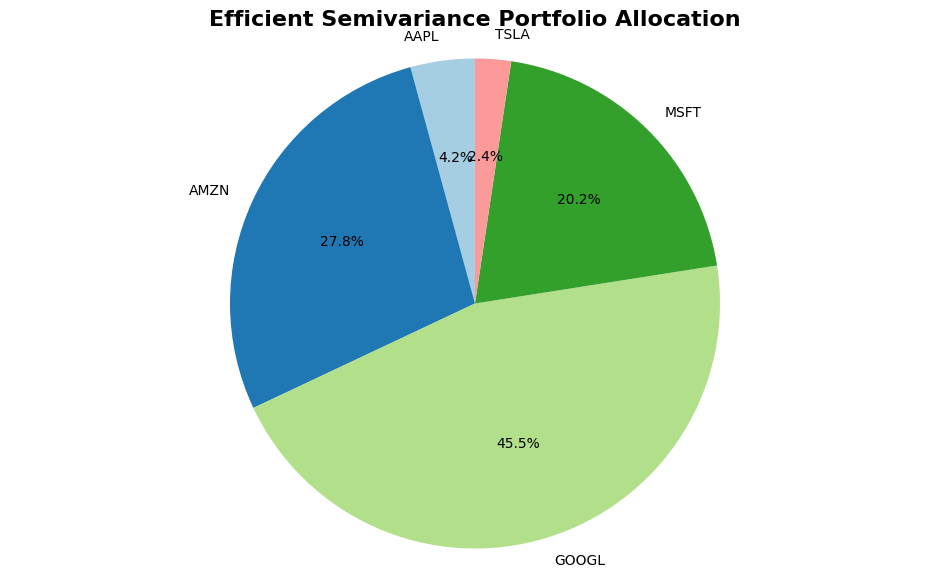

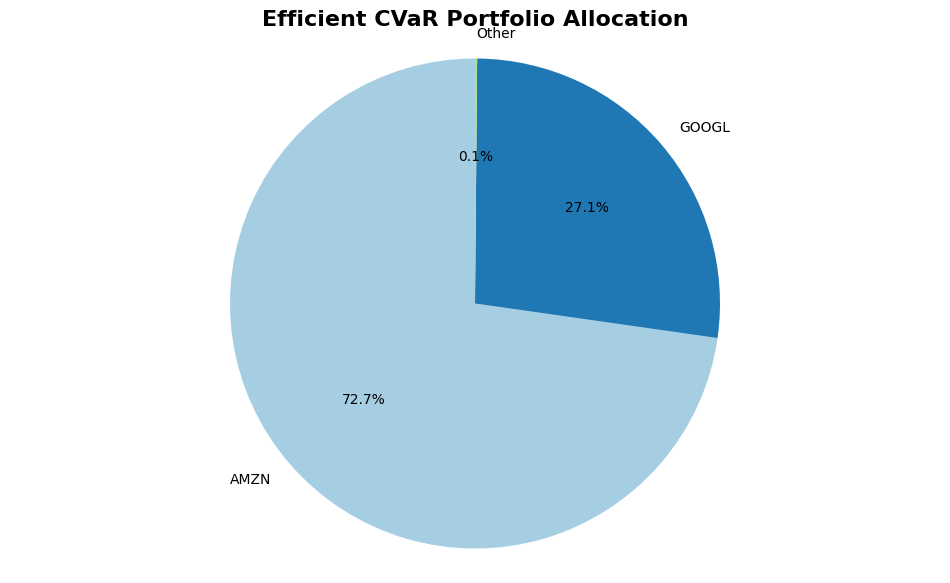

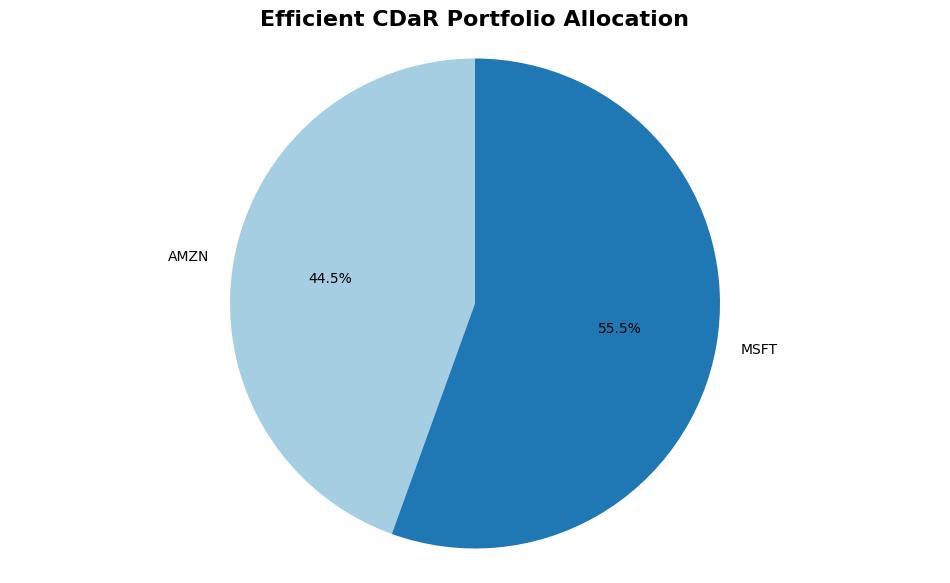

In [21]:
# Plot results
plot_portfolio_weights(sv_weights, "Efficient Semivariance Portfolio Allocation")
plot_portfolio_weights(cvar_weights, "Efficient CVaR Portfolio Allocation")
plot_portfolio_weights(cdar_weights, "Efficient CDaR Portfolio Allocation")

### Plot cumulative returns

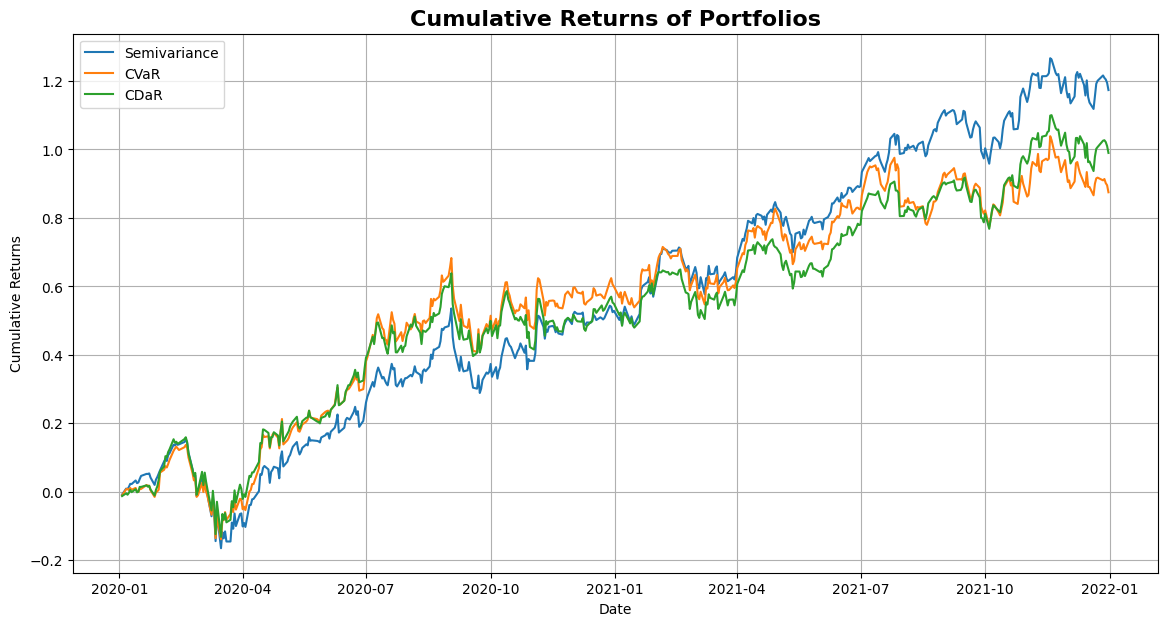

In [22]:
# Plot cumulative returns
returns_dict = {"Semivariance": sv_returns, "CVaR": cvar_returns, "CDaR": cdar_returns}
plot_cumulative_returns(returns_dict, "Cumulative Returns of Portfolios")

### Plot performance metrics

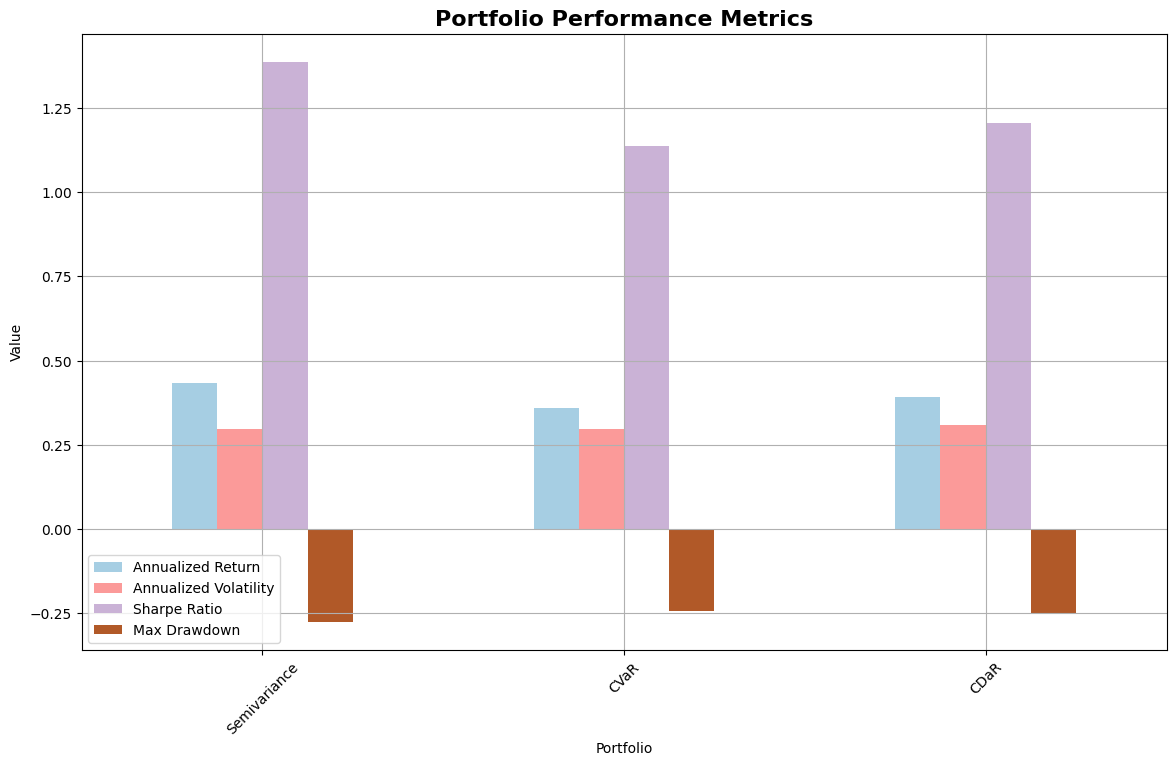

In [23]:
# Plot performance metrics
metrics_dict = {"Semivariance": sv_metrics, "CVaR": cvar_metrics, "CDaR": cdar_metrics}
plot_performance_metrics(metrics_dict)